1.basic bias model
==

In [14]:
import json
from math import sqrt

def readData(filename, list):
	with open(filename, 'r') as f:
		for line in f:
			list.append(json.loads(line))

#load the trainning data
trainDatas = []
readData('data_preprocess/trainOutNoZero.json', trainDatas)
print("the number of users in trainning data is:" + str(len(trainDatas)) + "\n")
#print(trainDatas[0])

the number of users in trainning data is:9998



In [15]:
#construct the dict by itemID
trainReviews = {}#improve the speed of finding
for review in trainDatas:
    for rating in review["ratings"]:
        itemID = rating["itemID"]
        if itemID in trainReviews:
            trainReviews[itemID].append(rating)
        else:
            trainReviews[itemID] = [rating]
print('the number of distinct items is: ' + str(len(trainReviews)))

the number of distinct items is: 295455


In [16]:
#load the test data
testDatas = []
readData('data_preprocess/testOut1w.json', testDatas)
print("the number of users in test data is:" + str(len(testDatas)) + "\n")
#print(testDatas[0])

the number of users in test data is:10000



In [17]:
#the average of all rating
aveRate = 0
count = 0
for review in trainDatas:
    for rating in review["ratings"]:
        aveRate += int(rating["rating"])
        count += 1
aveRate /= float(count)
print('the overall average rating is: ' + str(aveRate))

the overall average rating is: 71.2783178904


In [18]:
def itemBias(itemID, aveRating):

    #    use the trainReviews(dict) which is sorted by itemId

    numRating = 0
    sumRating = 0
    if itemID in trainReviews:
        for rating in trainReviews[itemID]:
            numRating += 1
            sumRating += float(rating['rating'])
    else:#if there is no such itemID's rating the itemBias is zero
        return 0
    return sumRating / float(numRating) - aveRating

def userBias(userID, aveRating):

    #    use the trainOut format to find the userBias

    numRating = 0
    sumRating = 0
    for review in trainDatas:
        if review['userID'] == userID:
            for rating in review["ratings"]:
                numRating += 1
                sumRating += float(rating['rating'])
            break#if get the user info then stop the loop
    if numRating == 0:
        return 0
    return sumRating / float(numRating) - aveRating

#get the user bias matrix from train data
userBiases = {}
for review in trainDatas:
	userID = review['userID']
	userBiases[userID] = userBias(userID, aveRate)

#get the item bias matrix from train data
itemBiases = {}
for itemID in trainReviews:
    itemBiases[itemID] = itemBias(itemID, aveRate)

In [19]:
#check basic model RMSE
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    if userID not in userBiases:
        continue
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            squareSum += (aveRate + userBiases[userID] + itemBiases[itemID] - realRating) ** 2
            errors.append(aveRate + userBiases[userID] + itemBiases[itemID] - realRating)
        #if the current item does not exist in train data, the bias is zero
        else:
            squareSum += (aveRate + userBiases[userID] + 0 - realRating) ** 2
            errors.append(aveRate + userBiases[userID] + 0 - realRating)

RMSE = sqrt(squareSum / float(count))
print('the basic model RMSE is: ' + str(RMSE))
print('the number of views in test data is: ' + str(count))

the basic model RMSE is: 33.7583316241
the number of views in test data is: 59988


-94.4926036046
124.849977364


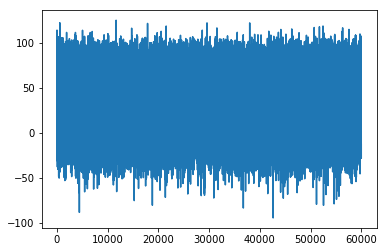

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
x = range(len(errors))
y = errors
plt.plot(x, y)
print min(errors)
print max(errors)

2.Add the taxnomy biases
=====

In [21]:
#===============================================taxonomy method
#read the 4 type's all ID
def readIDData(filename):
	list = []
	with open(filename, 'r') as f:
		for line in f:
			list.append(line[:-1])#eliminate the newline character
	return list
#use add taxonomy bias
trackList = readIDData('data_preprocess/track_out_idOnly.txt')
artistList = readIDData('data_preprocess/artistData1.txt')
albumList = readIDData('data_preprocess/album_out_idOnly.txt')
genreList = readIDData('data_preprocess/genreData1.txt')

print('the length of track list is:' + str(len(trackList)))
print('the length of artistList is:' + str(len(artistList)))
print('the length of albumList is:' + str(len(albumList)))
print('the length of genreList is:' + str(len(genreList)))
#print(len(genreList[0]))

the length of track list is:507172
the length of artistList is:27888
the length of albumList is:88909
the length of genreList is:992


In [22]:
##
#  extract the items biases with different types from the partial trainData
##
#extract the track bias
trackBiases = {}
for itemID in trackList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		trackBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		trackBiases[itemID] = 0
print('the size of trackBiases is: ' + str(len(trackBiases)))

#extract the album bias
albumBiases = {}
for itemID in albumList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		albumBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		albumBiases[itemID] = 0
print('the size of albumBiases is: ' + str(len(albumBiases)))

#extract the artist bias
artistBiases = {}
for itemID in artistList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		artistBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		artistBiases[itemID] = 0
print('the size of artistBiases is: ' + str(len(artistBiases)))

#extract the genre bias
genreBiases = {}
for itemID in genreList:
	if itemID in trainReviews:
		sumRating = 0
		numRating = 0
		for rating in trainReviews[itemID]:
			sumRating += float(rating['rating'])
			numRating += 1
		genreBiases[itemID] = float(sumRating) / float(numRating) - aveRate
	else:
		genreBiases[itemID] = 0
print('the size of genreBiases is: ' + str(len(genreBiases)))

the size of trackBiases is: 507172
the size of albumBiases is: 88909
the size of artistBiases is: 27888
the size of genreBiases is: 992


In [23]:
#read the tracks
trackDatas = []
readData('data_preprocess/trackOut.json', trackDatas)
print('the size of track is: ' + str(len(trackDatas)))
print(trackDatas[0])

the size of track is: 507172
{u'trackID': u'0', u'artistID': u'587636', u'genreList': [u'349388', u'159199', u'303996', u'378770'], u'albumID': u'224058'}


In [24]:
#construct the dict by trackID
trackDict = {}
for track in trackDatas:
    trackDict[track['trackID']] = track
print('the number of tracks is: ' + str(len(trackDict)))
print(trackDict['0'])

the number of tracks is: 507172
{u'trackID': u'0', u'artistID': u'587636', u'genreList': [u'349388', u'159199', u'303996', u'378770'], u'albumID': u'224058'}


In [25]:
#expand the track bias
def getTaxTrackBias(itemID):
    if itemID in trackBiases:#should check this, since not all track in this partial train data
        bi = trackBiases[itemID]
    else:
        return 0
    
    genreRateSum = 0
    genreNum = 0
    biGenre = 0
    biAlbum = 0
    biArtist = 0
    
    track = trackDict[itemID]
    if track["albumID"] in albumBiases:
        #assume that the track only belong to exactly one album
        biAlbum = albumBiases[track["albumID"]]
            
    if track['artistID'] in artistBiases:
        #assume that the track only belong to exactly one artist
        biArtist = artistBiases[track["artistID"]]
            
    for genreID in track['genreList']:
        if genreID in genreBiases:
            genreRateSum += genreBiases[genreID]
            genreNum += 1
        if genreNum != 0:
            biGenre = float(genreRateSum) / float(genreNum)
        
    taxTrackBias = bi + biAlbum + biArtist + biGenre

    return taxTrackBias

In [26]:
#pre-build the trackTaxBiases
trackTaxBiases = {}
for itemID in trainReviews:
    if itemID in trackBiases:
        trackTaxBiases[itemID] = getTaxTrackBias(itemID)
print('the size of track tax biases is: ' + str(len(trackTaxBiases)))
# print(trackTaxBiases['0'])

the size of track tax biases is: 225515


In [27]:
#read the albums 
albumDatas = []
readData('data_preprocess/albumOut.json', albumDatas)
print('the size of album is: ' + str(len(albumDatas)))
print(albumDatas[0])

the size of album is: 88909
{u'albumID': u'9', u'artistID': u'7863', u'genreList': [u'600770', u'584872', u'247563']}


In [28]:
#construct the dict by albumID
albumDict = {}
for album in albumDatas:
    albumDict[album['albumID']] = album
print('the number of albums is: ' + str(len(albumDict)))
print(albumDict['9'])

the number of albums is: 88909
{u'albumID': u'9', u'artistID': u'7863', u'genreList': [u'600770', u'584872', u'247563']}


In [29]:
#expand the album bias
def getTaxAlbumBias(itemID):
    if itemID in albumBiases:#should check this, since not all album in this partial data
		bi = albumBiases[itemID]
    else:
		return 0
    
    genreRateSum = 0
    genreNum = 0
    biGenre = 0
    biArtist = 0
    
    album = albumDict[itemID]
    if album['artistID'] in artistBiases:
        #assume that the album only belong to exactly one artist
        biArtist = artistBiases[album["artistID"]]
            
    for genreID in album['genreList']:
        if genreID in genreBiases:
            genreRateSum += genreBiases[genreID]
            genreNum += 1
        if genreNum != 0:
            biGenre = float(genreRateSum) / float(genreNum)
    
    taxAlbumBias = bi + biArtist + biGenre
    return taxAlbumBias

In [30]:
#pre-build the albumTaxBiases
albumTaxBiases = {}
for itemID in trainReviews:
    if itemID in albumBiases:
        albumTaxBiases[itemID] = getTaxAlbumBias(itemID)
print('the size of album tax biases is: ' + str(len(albumTaxBiases)))
print(albumTaxBiases['9'])

the size of album tax biases is: 53033
-2.10935849503


In [31]:
#check the taxonomy bias model RMSE
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    if userID not in userBiases:
        continue
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            if itemID in trackBiases:
                curItemBias = trackTaxBiases[itemID]              
            elif itemID in albumBiases:
                curItemBias = albumTaxBiases[itemID]               
            else:
                curItemBias = itemBiases[itemID]
        #if the current item does not exist in train data, the bias is zero
        else:
            curItemBias = 0
        curUserBias = userBiases[userID]
            
        squareSum += (aveRate + curItemBias + curUserBias - realRating) ** 2
        errors.append(aveRate + curItemBias + curUserBias - realRating)

RMSE = sqrt(squareSum / float(count))
print('the item taxonomy model RMSE is: ' + str(RMSE))
print('the number of views in test data is: ' + str(count))

the item taxonomy model RMSE is: 34.4441071989
the number of views in test data is: 59988


-145.106025185
150.946114448


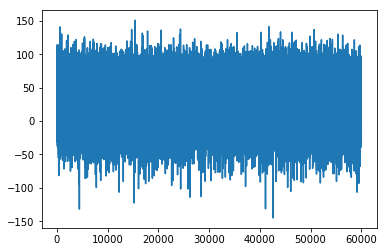

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
x = range(len(errors))
y = errors
plt.plot(x, y)
print min(errors)
print max(errors)

In [22]:
import numpy as np
ind = np.argmax(errors)
print ind
print errors[24356]

15422
-9.53118975932


3.add user taxonomy bias
==

In [33]:
def userTaxBias(userID):
    bu = userBiases[userID]
    userTaxBiases = {'track':0,'album':0,'artist':0,'genre':0}
    numTrackRate = 0
    numAlbumRate = 0
    numArtistRate = 0
    numGenreRate = 0
    
    sumTrackRate = 0
    sumAlbumRate = 0
    sumArtistRate = 0
    sumGenreRate = 0

#     review = trainDatas[int(userID) - 30000]#since the ID of users is continuous
    for curReview in trainDatas:
        if curReview['userID'] == userID:
            review = curReview#since the ID of users is continuous
            break
    
    for rating in review['ratings']:
        itemID = rating['itemID']
        score = float(rating['rating'])
        if itemID in trackBiases:
            sumTrackRate += score
            numTrackRate += 1
        elif itemID in albumBiases:
            sumAlbumRate += score
            numAlbumRate += 1
        elif itemID in artistBiases:
            sumArtistRate += score
            numArtistRate += 1
        elif itemID in genreBiases:
            sumGenreRate += score
            numGenreRate += 1
    if numTrackRate != 0:
        userTaxBiases['track'] = sumTrackRate / float(numTrackRate) - aveRate
    if numAlbumRate != 0:   
        userTaxBiases['album'] = sumAlbumRate / float(numAlbumRate) - aveRate
    if numArtistRate != 0:
        userTaxBiases['artist'] = sumArtistRate / float(numArtistRate) - aveRate
    if numGenreRate != 0:
        userTaxBiases['genre'] = sumGenreRate / float(numGenreRate) - aveRate
    
    return userTaxBiases

In [34]:
#pre-build the tax user biases
userTaxBiases = {}
for review in trainDatas:
    userID = review['userID']
    userTaxBiases[userID] = userTaxBias(userID)
print('the number of users in train data is: ' + str(len(userTaxBiases)))
# print(userTaxBiases['0'])

the number of users in train data is: 9998


In [35]:
#check the RMSE with full taxonomy bias model
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    if userID not in userBiases:
        continue
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            if itemID in trackBiases:
                curItemBias = trackTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['track']
            elif itemID in albumBiases:
                curItemBias = albumTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['album']
            else:
                if itemID in artistBiases:
                    curUserBias = userTaxBiases[userID]['artist']
                elif itemID in genreBiases:
                    curUserBias = userTaxBiases[userID]['genre']
                curItemBias = itemBiases[itemID]
        #if the current item does not exist in train data, the bias is zero
        else:
            curItemBias = 0
        squareSum += (aveRate + curItemBias + curUserBias - realRating) ** 2 
        errors.append(aveRate + curItemBias + curUserBias - realRating)
#         squareSum += (aveRate + userBiases[userID] + curItemBias + curUserBias - realRating) ** 2

            
RMSE = sqrt(squareSum / float(count))
print('the full taxonomy model RMSE is: ' + str(RMSE))
print('the number of views in test data is: ' + str(count))

the full taxonomy model RMSE is: 33.8114327785
the number of views in test data is: 59988


-141.361893729
143.008363309


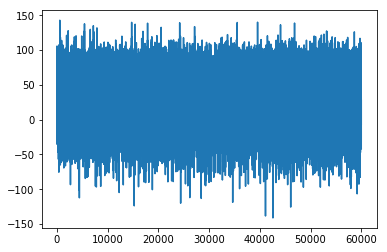

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
x = range(len(errors))
y = errors
plt.plot(x, y)
print min(errors)
print max(errors)

the full taxonomy model RMSE is: 54.6062826709 (the userItem add the original one)

the full taxonomy model RMSE is: 37.4768260566

go to use the other 1w users to test the model and to see the different RMSE

4. add user session model
===

In [38]:
def getUserSessionBias(ratings):
    userSessionBias = {}
    count = {}
    for rating in ratings:
        number = rating['number']
        if number in userSessionBias:
            userSessionBias[number] += float(rating['rating'])
            count[number] += 1
        else:
            userSessionBias[number] = float(rating['rating'])
            count[number] = 1
    for number in userSessionBias.keys():
        userSessionBias[number] = userSessionBias[number] / float(count[number]) - aveRate
    return userSessionBias

In [39]:
#get the user's session biases 
userSessionBiases = {}
for review in trainDatas:
    userID = review['userID']
    userSessionBiases[userID] = getUserSessionBias(review['ratings'])

In [40]:
#check the RMSE with addtion of user session bias
predRatings = []
realRatings = []
errors = []
count = 0
squareSum = 0
for review in testDatas:
    userID = review['userID']
    if userID not in userBiases:
        continue
    for rating in review['ratings']:
        itemID = rating['itemID']
        realRating = float(rating['rating'])
        count += 1
        if itemID in itemBiases:
            if itemID in trackBiases:
                curItemBias = trackTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['track']
            elif itemID in albumBiases:
                curItemBias = albumTaxBiases[itemID]
                curUserBias = userTaxBiases[userID]['album']
            else:
                if itemID in artistBiases:
                    curUserBias = userTaxBiases[userID]['artist']
                elif itemID in genreBiases:
                    curUserBias = userTaxBiases[userID]['genre']
                curItemBias = itemBiases[itemID]
        #if the current item does not exist in train data, the bias is zero
        else:
            curItemBias = 0
        #check if user has session bias
        if rating['number'] in userSessionBiases[userID]:
            curUserBias += userSessionBiases[userID][rating['number']]
        
        
        squareSum += (aveRate + curItemBias + curUserBias - realRating) ** 2 
        predRatings.append(aveRate + curItemBias + curUserBias)
        realRatings.append(realRating)
        errors.append(aveRate + curItemBias + curUserBias - realRating)
#         squareSum += (aveRate + userBiases[userID] + curItemBias + curUserBias - realRating) ** 2

            
RMSE = sqrt(squareSum / float(count))
print('the full taxonomy model with user session bias RMSE is: ' + str(RMSE))
print('the number of views in test data is: ' + str(count))

the full taxonomy model with user session bias RMSE is: 37.9934142785
the number of views in test data is: 59988


-183.806635781
214.886728439


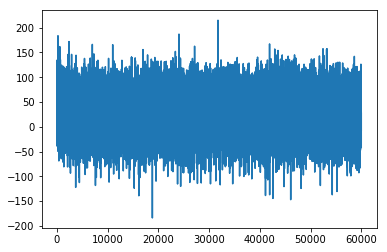

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
x = range(len(errors))
y = errors
plt.plot(x, y)
print min(errors)
print max(errors)

the data shows that the user could rate too many items in one minute which is not useful to do user dynamics bias model

5. Add Shining Point to Model
===

In [12]:
#delete users who rating=0 
import json
def cutDataNoZero(input_filename, output_filename,lines):
    '''
        to eliminate the rating with 0 from the preproccessed file
    '''
    with open(input_filename, 'r') as f:
        for i in range(lines):
            curlist = []
            curUserReview = json.loads(f.readline())
            for j in range (len(curUserReview['ratings'])):
                if int(curUserReview['ratings'][j]['rating']) != 0:
                    curlist.append(curUserReview['ratings'][j])
            if len(curlist)==0:
                continue
            curUserReview['ratings'] = curlist
            with open (output_filename,'a') as wf:
                json.dump(curUserReview,wf)
                wf.write('\n')

In [13]:
cutDataNoZero('data_preprocess/trainOut1w.json', 'data_preprocess/trainOutNoZero.json',10000)

Then redo the modeling we could get the better evaluation